In [1]:
import json
import joblib
from pprint import pprint
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import lightgbm as lgb
from lightgbm.callback import log_evaluation, early_stopping

from isic_helper import DotDict
from isic_helper import compute_auc, compute_pauc

pd.options.display.max_columns = 1000

In [2]:
cfg = DotDict()
cfg.seed = 2022

cfg.models_output_dir = "models"
cfg.model_name = "lgb_v5"

cfg.fold_method = "gkf"
cfg.sampling_ratio = 0.01

In [3]:
id_column = "isic_id"
target_column = "target"
group_column = "patient_id"
if cfg.fold_method == "gkf":
    print("Using GroupKFold")
    fold_column = "gkf_fold"
elif cfg.fold_method == "sgkf":
    print("Using StratifiedGroupKFold")
    fold_column = "sgkf_fold"
else:
    raise ValueError(f"Fold method {fold_method} not supported")

numerical_features = [
    "age_approx",
    "clin_size_long_diam_mm",
    "tbp_lv_A", "tbp_lv_Aext",
    "tbp_lv_B", "tbp_lv_Bext",
    "tbp_lv_C", "tbp_lv_Cext",
    "tbp_lv_H", "tbp_lv_Hext",
    "tbp_lv_L", "tbp_lv_Lext",
    "tbp_lv_areaMM2",
    "tbp_lv_area_perim_ratio",
    "tbp_lv_color_std_mean",
    "tbp_lv_deltaA", "tbp_lv_deltaB", "tbp_lv_deltaL", "tbp_lv_deltaLB", "tbp_lv_deltaLBnorm",
    "tbp_lv_eccentricity",
    "tbp_lv_minorAxisMM",
    "tbp_lv_nevi_confidence",
    "tbp_lv_norm_border", "tbp_lv_norm_color",
    "tbp_lv_perimeterMM",
    "tbp_lv_radial_color_std_max",
    "tbp_lv_stdL", "tbp_lv_stdLExt",
    "tbp_lv_symm_2axis", "tbp_lv_symm_2axis_angle",
    "tbp_lv_x", "tbp_lv_y", "tbp_lv_z",
]

ord_categorical_features = [
    "sex",
    "anatom_site_general", 
    "tbp_lv_location",
    "tbp_tile_type",
    "tbp_lv_location_simple",
]

ohe_categorical_features = [ 
    "attribution",
]

def preprocess(df):
    df["anatom_site_general"] = df["anatom_site_general"].fillna("missing_site")
    df["sex"] = df["sex"].fillna("missing_sex")
    df["tbp_tile_type"] = df["tbp_tile_type"].map({"3D: white": "white", "3D: XP": "XP"})
    attribution_mapper = {
        "Memorial Sloan Kettering Cancer Center": "MSKCC",
        "ACEMID MIA": "ACEMIDMIA",
        "Department of Dermatology, Hospital Clínic de Barcelona": "DoD_HCB",
        "University Hospital of Basel": "UHB",
        "Frazer Institute, The University of Queensland, Dermatology Research Centre": "FI_TUQ-DRC",
        "Department of Dermatology, University of Athens, Andreas Syggros Hospital of Skin and Venereal Diseases, Alexander Stratigos, Konstantinos Liopyris": "DoD_UA",
        "ViDIR Group, Department of Dermatology, Medical University of Vienna": "ViDIR"
    }
    df["attribution"] = df["attribution"].map(attribution_mapper)
    return df

def norm_feature(df, value_col, group_cols=[group_column], err=1e-5):
    stats = ["mean", "std"]
    tmp = df.groupby(group_cols)[value_col].agg(stats)
    tmp.columns = [f"{value_col}_{stat}" for stat in stats]
    tmp.reset_index(inplace=True)
    df = df.merge(tmp, on=group_cols, how="left")
    feature_name = f"{value_col}_patient_norm"
    df[feature_name] = ((df[value_col] - df[f"{value_col}_mean"]) / 
                                       (df[f"{value_col}_std"] + err))
    return df, feature_name

def count_features(df, col):
    tmp = df[[id_column, group_column, col]].pivot_table(
        values=id_column, 
        index=group_column, 
        columns=col, 
        aggfunc="count", 
        fill_value=0)
    feature_cols = tmp.columns.tolist()
    tmp.reset_index(inplace=True)
    tmp.index.name = None
    df = df.merge(tmp, on=group_column, how="left")
    return df, feature_cols

def feature_engineering(df, err=1e-5):
    new_num_cols = []
    
    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    new_num_cols += ["lesion_size_ratio"]
    
    df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / df["tbp_lv_perimeterMM"]**2
    new_num_cols += ["lesion_shape_index"]
    
    df["hue_contrast"] = np.abs(df["tbp_lv_H"] - df["tbp_lv_Hext"])
    new_num_cols += ["hue_contrast"]
    
    df["luminance_contrast"] = np.abs(df["tbp_lv_L"] - df["tbp_lv_Lext"])
    new_num_cols += ["luminance_contrast"]
    
    df["lesion_color_difference"] = np.sqrt(df["tbp_lv_deltaA"]**2 +
                                            df["tbp_lv_deltaB"]**2 +
                                            df["tbp_lv_deltaL"]**2)
    new_num_cols += ["lesion_color_difference"]
    
    df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
    new_num_cols += ["border_complexity"]
    
    df["color_uniformity"] = df["tbp_lv_color_std_mean"] / (df["tbp_lv_radial_color_std_max"] + err)
    new_num_cols += ["color_uniformity"]
    
    df["position_distance_3d"] = np.sqrt(df["tbp_lv_x"]**2 +
                                         df["tbp_lv_y"]**2 +
                                         df["tbp_lv_z"]**2)
    new_num_cols += ["position_distance_3d"]
    
    df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]
    new_num_cols += ["perimeter_to_area_ratio"]
    
    df["area_to_perimeter_ratio"] = df["tbp_lv_areaMM2"] / df["tbp_lv_perimeterMM"]
    new_num_cols += ["area_to_perimeter_ratio"]
    
    df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
    new_num_cols += ["lesion_visibility_score"]
    
    df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
    new_num_cols += ["symmetry_border_consistency"]
    
    df["consistency_symmetry_border"] = (df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"] /
                                         (df["tbp_lv_symm_2axis"] + df["tbp_lv_norm_border"]))
    new_num_cols += ["consistency_symmetry_border"]
    
    df["color_consistency"] = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]
    new_num_cols += ["color_consistency"]
    
#     df["consistency_color"] = (df["tbp_lv_stdL"] * df["tbp_lv_Lext"] /
#                                (df["tbp_lv_stdL"] * df["tbp_lv_Lext"]))
#     new_num_cols += ["consistency_color"]
    
    df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
    new_num_cols += ["size_age_interaction"]
    
    df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
    new_num_cols += ["hue_color_std_interaction"]
    
    df["lesion_severity_index"] = (df["tbp_lv_norm_border"] +
                                   df["tbp_lv_norm_color"] +
                                   df["tbp_lv_eccentricity"]) / 3
    new_num_cols += ["lesion_severity_index"]
    
    df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]
    new_num_cols += ["shape_complexity_index"]
    
    df["color_contrast_index"] = (df["tbp_lv_deltaA"] +
                                  df["tbp_lv_deltaB"] + 
                                  df["tbp_lv_deltaL"] +
                                  df["tbp_lv_deltaLBnorm"])
    new_num_cols += ["color_contrast_index"]
    
    df["log_lesion_area"] = np.log1p(df["tbp_lv_areaMM2"])
    new_num_cols += ["log_lesion_area"]
    
    df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"]
    new_num_cols += ["normalized_lesion_size"]
    
    df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
    new_num_cols += ["mean_hue_difference"]
    
    df["std_dev_contrast"] = np.sqrt((df["tbp_lv_deltaA"]**2 +
                                      df["tbp_lv_deltaB"]**2 + 
                                      df["tbp_lv_deltaL"]**2) / 3)
    new_num_cols += ["std_dev_contrast"]
    
    df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + 
                                         df["tbp_lv_area_perim_ratio"] +
                                         df["tbp_lv_symm_2axis"]) / 3
    new_num_cols += ["color_shape_composite_index"]
    
    df["lesion_orientation_3d"] = np.arctan2(df["tbp_lv_y"], df["tbp_lv_x"])
    new_num_cols += ["lesion_orientation_3d"]
    
    df["overall_color_difference"] = (df["tbp_lv_deltaA"] + 
                                      df["tbp_lv_deltaB"] + 
                                      df["tbp_lv_deltaL"]) / 3
    new_num_cols += ["overall_color_difference"]
    
    df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
    new_num_cols += ["symmetry_perimeter_interaction"]
    
    df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] +
                                        df["tbp_lv_eccentricity"] +
                                        df["tbp_lv_norm_color"] +
                                        df["tbp_lv_symm_2axis"]) / 4
    new_num_cols += ["comprehensive_lesion_index"]
    
    df["color_variance_ratio"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_stdLExt"]
    new_num_cols += ["color_variance_ratio"]
    
    df["border_color_interaction"] = df["tbp_lv_norm_border"] * df["tbp_lv_norm_color"]
    new_num_cols += ["border_color_interaction"]
    
    df["border_color_interaction_2"] = ((df["tbp_lv_norm_border"] * df["tbp_lv_norm_color"]) /
                                        (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"]))
    new_num_cols += ["border_color_interaction_2"]
    
    df["size_color_contrast_ratio"] = df["clin_size_long_diam_mm"] / df["tbp_lv_deltaLBnorm"]
    new_num_cols += ["size_color_contrast_ratio"]
    
    df["age_normalized_nevi_confidence"] = df["tbp_lv_nevi_confidence"] / df["age_approx"]
    new_num_cols += ["age_normalized_nevi_confidence"]
    
    df["age_normalized_nevi_confidence_2"] = np.sqrt(df["tbp_lv_nevi_confidence"]**2 + df["age_approx"]**2)
    new_num_cols += ["age_normalized_nevi_confidence_2"]
    
    df["color_asymmetry_index"] = df["tbp_lv_radial_color_std_max"] * df["tbp_lv_symm_2axis"]
    new_num_cols += ["color_asymmetry_index"]
    
    df["volume_approximation_3d"] = df["tbp_lv_areaMM2"] * np.sqrt(df["tbp_lv_x"]**2 +
                                                                   df["tbp_lv_y"]**2 +
                                                                   df["tbp_lv_z"]**2)
    new_num_cols += ["volume_approximation_3d"]
    
    df["color_range"] = (np.abs(df["tbp_lv_L"] - df["tbp_lv_Lext"]) +
                         np.abs(df["tbp_lv_A"] - df["tbp_lv_Aext"]) +
                         np.abs(df["tbp_lv_B"] - df["tbp_lv_Bext"]))
    new_num_cols += ["color_range"]
    
    df["shape_color_consistency"] = df["tbp_lv_eccentricity"] * df["tbp_lv_color_std_mean"]
    new_num_cols += ["shape_color_consistency"]
    
    df["border_length_ratio"] = df["tbp_lv_perimeterMM"] / np.sqrt(2 * df["tbp_lv_areaMM2"])
    new_num_cols += ["border_length_ratio"]
    
    df["age_size_symmetry_index"] = (df["age_approx"] *
                                     df["clin_size_long_diam_mm"] *
                                     df["tbp_lv_symm_2axis"])
    new_num_cols += ["age_size_symmetry_index"]
    
    df["age_area_symmetry"] = (df["age_approx"] *
                               df["tbp_lv_areaMM2"] *
                               df["tbp_lv_symm_2axis"])
    new_num_cols += ["age_area_symmetry"]
    
    for col in numerical_features + new_num_cols:
        df, feature_name = norm_feature(df, col)
        new_num_cols += [feature_name]
        
    df, feature_cols = count_features(df, "anatom_site_general")
    new_num_cols += feature_cols
    
    df["num_images"] = df.patient_id.map(df.groupby(group_column)[id_column].count())
    new_num_cols += ["num_images"]

    return df, new_num_cols

Using GroupKFold


In [4]:
INPUT_PATH = Path("../input/isic-2024-challenge/")
MODELS_OUTPUT_PATH = Path(f"{cfg.models_output_dir}")
MODELS_OUTPUT_PATH.mkdir(exist_ok=True)

train_metadata = pd.read_csv(INPUT_PATH / "train-metadata.csv", low_memory=False, na_values=["NA"])
test_metadata = pd.read_csv(INPUT_PATH / "test-metadata.csv", low_memory=False, na_values=["NA"])

folds_df = pd.read_csv("/kaggle/input/isic-scd-folds/folds.csv")
train_metadata = train_metadata.merge(folds_df[[id_column, group_column, fold_column]], on=[id_column, group_column], how="inner")
print(f"Train data size: {train_metadata.shape}")
print(f"Test data size: {test_metadata.shape}")

train_metadata = preprocess(train_metadata)
test_metadata = preprocess(test_metadata)

train_metadata, new_num_cols = feature_engineering(train_metadata)
test_metadata, _ = feature_engineering(test_metadata)

numerical_features += new_num_cols

Train data size: (401059, 56)
Test data size: (3, 44)


In [5]:
mixed_encoded_preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", numerical_features),
        (
            "ord_categorical",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-2, encoded_missing_value=-1, dtype=int),
            ord_categorical_features,
        ),
        (
            "ohe_categorical",
            OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown="ignore"),
            ohe_categorical_features
        )
    ],
    verbose_feature_names_out=False,

)
mixed_encoded_preprocessor.set_output(transform="pandas")

with open(f"{cfg.model_name}_encoder.joblib", "wb") as f:
    joblib.dump(mixed_encoded_preprocessor, f)

In [6]:
train_ids = train_metadata[id_column]
groups = train_metadata[group_column]
folds = train_metadata[fold_column]

enc = mixed_encoded_preprocessor.fit(train_metadata)
X_train = enc.transform(train_metadata)
y_train = train_metadata[target_column]

categorical_features = ord_categorical_features[:]
for ohe_col in ohe_categorical_features:
    categorical_features += [col for col in X_train.columns if col.startswith(ohe_col)]

print(f"Total number of columns: {len(X_train.columns)}")

Total number of columns: 169


In [7]:
X_train.head()

,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,lesion_size_ratio,lesion_shape_index,hue_contrast,luminance_contrast,lesion_color_difference,border_complexity,color_uniformity,position_distance_3d,perimeter_to_area_ratio,area_to_perimeter_ratio,lesion_visibility_score,symmetry_border_consistency,consistency_symmetry_border,color_consistency,size_age_interaction,hue_color_std_interaction,lesion_severity_index,shape_complexity_index,color_contrast_index,log_lesion_area,normalized_lesion_size,mean_hue_difference,std_dev_contrast,color_shape_composite_index,lesion_orientation_3d,overall_color_difference,symmetry_perimeter_interaction,comprehensive_lesion_index,color_variance_ratio,border_color_interaction,border_color_interaction_2,size_color_contrast_ratio,age_normalized_nevi_confidence,age_normalized_nevi_confidence_2,color_asymmetry_index,volume_approximation_3d,color_range,shape_color_consistency,border_length_ratio,age_size_symmetry_index,age_area_symmetry,age_approx_patient_norm,clin_size_long_diam_mm_patient_norm,tbp_lv_A_patient_norm,tbp_lv_Aext_patient_norm,tbp_lv_B_patient_norm,tbp_lv_Bext_patient_norm,tbp_lv_C_patient_norm,tbp_lv_Cext_patient_norm,tbp_lv_H_patient_norm,tbp_lv_Hext_patient_norm,tbp_lv_L_patient_norm,tbp_lv_Lext_patient_norm,tbp_lv_areaMM2_patient_norm,tbp_lv_area_perim_ratio_patient_norm,tbp_lv_color_std_mean_patient_norm,tbp_lv_deltaA_patient_norm,tbp_lv_deltaB_patient_norm,tbp_lv_deltaL_patient_norm,tbp_lv_deltaLB_patient_norm,tbp_lv_deltaLBnorm_patient_norm,tbp_lv_eccentricity_patient_norm,tbp_lv_minorAxisMM_patient_norm,tbp_lv_nevi_confidence_patient_norm,tbp_lv_norm_border_patient_norm,tbp_lv_norm_color_patient_norm,tbp_lv_perimeterMM_patient_norm,tbp_lv_radial_color_std_max_patient_norm,tbp_lv_stdL_patient_norm,tbp_lv_stdLExt_patient_norm,tbp_lv_symm_2axis_patient_norm,tbp_lv_symm_2axis_angle_patient_norm,tbp_lv_x_patient_norm,tbp_lv_y_patient_norm,tbp_lv_z_patient_norm,lesion_size_ratio_patient_norm,lesion_shape_index_patient_norm,hue_contrast_patient_norm,luminance_contrast_patient_norm,lesion_color_difference_patient_norm,border_complexity_patient_norm,color_uniformity_patient_norm,position_distance_3d_patient_norm,perimeter_to_area_ratio_patient_norm,area_to_perimeter_ratio_patient_norm,lesion_visibility_score_patient_norm,symmetry_border_consistency_patient_norm,consistency_symmetry_border_patient_norm,color_consistency_patient_norm,size_age_interaction_patient_norm,hue_color_std_interaction_patient_norm,lesion_severity_index_patient_norm,shape_complexity_index_patient_norm,color_contrast_index_patient_norm,log_lesion_area_patient_norm,normalized_lesion_size_patient_norm,mean_hue_difference_patient_norm,std_dev_contrast_patient_norm,color_shape_composite_index_patient_norm,lesion_orientation_3d_patient_norm,overall_color_difference_patient_norm,symmetry_perimeter_interaction_patient_norm,comprehensive_lesion_index_patient_norm,color_variance_ratio_patient_norm,border_color_interaction_patient_norm,border_color_interaction_2_patient_norm,size_color_contrast_ratio_patient_norm,age_normalized_nevi_confidence_patient_norm,age_normalized_nevi_confidence_2_patient_norm,color_asymmetry_index_patient_norm,volume_approximation_3d_patient_norm,color_range_patient_norm,shape_color_consistency_patient_norm,border_length_ratio_patient_norm,age_size_symmetry_index_patient_norm,age_area_symmetry_patient_norm,anterior torso,head/neck,lower extremity,missing_site,posterior torso,upper extremity,num_images,sex,anatom_site_general,tbp_lv_location,tbp

In [8]:
X_train.columns.tolist()

['age_approx',
 'clin_size_long_diam_mm',
 'tbp_lv_A',
 'tbp_lv_Aext',
 'tbp_lv_B',
 'tbp_lv_Bext',
 'tbp_lv_C',
 'tbp_lv_Cext',
 'tbp_lv_H',
 'tbp_lv_Hext',
 'tbp_lv_L',
 'tbp_lv_Lext',
 'tbp_lv_areaMM2',
 'tbp_lv_area_perim_ratio',
 'tbp_lv_color_std_mean',
 'tbp_lv_deltaA',
 'tbp_lv_deltaB',
 'tbp_lv_deltaL',
 'tbp_lv_deltaLB',
 'tbp_lv_deltaLBnorm',
 'tbp_lv_eccentricity',
 'tbp_lv_minorAxisMM',
 'tbp_lv_nevi_confidence',
 'tbp_lv_norm_border',
 'tbp_lv_norm_color',
 'tbp_lv_perimeterMM',
 'tbp_lv_radial_color_std_max',
 'tbp_lv_stdL',
 'tbp_lv_stdLExt',
 'tbp_lv_symm_2axis',
 'tbp_lv_symm_2axis_angle',
 'tbp_lv_x',
 'tbp_lv_y',
 'tbp_lv_z',
 'lesion_size_ratio',
 'lesion_shape_index',
 'hue_contrast',
 'luminance_contrast',
 'lesion_color_difference',
 'border_complexity',
 'color_uniformity',
 'position_distance_3d',
 'perimeter_to_area_ratio',
 'area_to_perimeter_ratio',
 'lesion_visibility_score',
 'symmetry_border_consistency',
 'consistency_symmetry_border',
 'color_consisten

In [9]:
def pauc_80(y_true, y_pred):
    score_value = compute_pauc(y_true, y_pred, min_tpr=0.8)   
    return "pauc_80", score_value, True


params = {
    'objective':        'binary',
    'verbosity':        -1,
    'boosting_type':    'gbdt',
    "metric":           "custom",
    'random_state':     cfg.seed,
    'lambda_l1':        0.08758718919397321, 
    'lambda_l2':        0.0039689175176025465, 
    'learning_rate':    0.02, 
    'max_depth':        4, 
    'num_leaves':       103, 
    'colsample_bytree': 0.8329551585827726, 
    'colsample_bynode': 0.4025961355653304, 
    'bagging_fraction': 0.7738954452473223, 
    'bagging_freq':     4, 
    'min_data_in_leaf': 85, 
    'scale_pos_weight': 2.7984184778875543,
}
num_rounds = 2000
es_rounds = 150
log_rounds = 50

In [10]:
best_num_rounds = {}
val_auc_scores = {}
val_pauc_scores = {}
all_folds = np.sort(folds.unique())
oof_predictions = np.zeros(X_train.shape[0])
for fold in all_folds:
    if fold < 0:
        continue
    print(f"Running fold: {fold}")
    dev_index = folds[folds != fold].index
    val_index = folds[folds == fold].index
    
    X_dev = X_train.loc[dev_index, :]
    y_dev = y_train[dev_index]
    
    X_val = X_train.loc[val_index, :]
    y_val = y_train[val_index]
    
    model = Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=cfg.sampling_ratio, random_state=cfg.seed)),
        ('classifier', lgb.LGBMClassifier(n_estimators=num_rounds, **params)),
    ])
    model.fit(X_dev, y_dev,
              classifier__eval_set=(X_val, y_val), classifier__eval_metric=pauc_80,
              classifier__callbacks=[
                        early_stopping(stopping_rounds=es_rounds, first_metric_only=True), 
                        log_evaluation(log_rounds)
                ]
             )
    best_num_rounds[f"fold_{fold}"] = model._final_estimator.best_iteration_
    
    val_preds = model.predict_proba(X_val)[:, -1]
    oof_predictions[val_index] = val_preds
    
    val_auc_scores[f"fold_{fold}"] = compute_auc(y_val, val_preds)
    val_pauc_scores[f"fold_{fold}"] = compute_pauc(y_val, val_preds, min_tpr=0.8)
    print("\n")
    
    with open(MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt", "wb") as f:
        joblib.dump(model, f)

print("Val AUC scores:")
pprint(val_auc_scores)
print("Val PAUC scores:")
pprint(val_pauc_scores)

oof_preds_df = pd.DataFrame({
    id_column: train_ids,
    group_column: groups,
    "fold": folds,
    target_column: y_train,
    f"oof_{cfg.model_name}": oof_predictions
})
oof_preds_df.to_csv(f"oof_preds_{cfg.model_name}.csv", index=False)

cv_auc_oof = compute_auc(oof_preds_df[target_column], oof_preds_df[f"oof_{cfg.model_name}"])
cv_pauc_oof = compute_pauc(oof_preds_df[target_column], oof_preds_df[f"oof_{cfg.model_name}"], min_tpr=0.8)

cv_auc_avg = np.mean(list(val_auc_scores.values()))
cv_pauc_avg = np.mean(list(val_pauc_scores.values()))

cv_auc_std = np.std(list(val_auc_scores.values()))
cv_pauc_std = np.std(list(val_pauc_scores.values()))

print(f"CV AUC OOF: {cv_auc_oof}")
print(f"CV PAUC OOF: {cv_pauc_oof}")
print(f"CV AUC AVG: {cv_auc_avg}")
print(f"CV PAUC AVG: {cv_pauc_avg}")
print(f"CV AUC STD: {cv_auc_std}")
print(f"CV PAUC STD: {cv_pauc_std}")
print(X_train.columns)

Running fold: 1
Training until validation scores don't improve for 150 rounds
[50]	valid_0's pauc_80: 0.179294
[100]	valid_0's pauc_80: 0.183219
[150]	valid_0's pauc_80: 0.184308
[200]	valid_0's pauc_80: 0.18515
[250]	valid_0's pauc_80: 0.185774
[300]	valid_0's pauc_80: 0.186097
[350]	valid_0's pauc_80: 0.186113
[400]	valid_0's pauc_80: 0.186311
[450]	valid_0's pauc_80: 0.186368
[500]	valid_0's pauc_80: 0.186377
[550]	valid_0's pauc_80: 0.186252
[600]	valid_0's pauc_80: 0.186233
[650]	valid_0's pauc_80: 0.185623
Early stopping, best iteration is:
[540]	valid_0's pauc_80: 0.186551
Evaluated only: pauc_80


Running fold: 2
Training until validation scores don't improve for 150 rounds
[50]	valid_0's pauc_80: 0.145809
[100]	valid_0's pauc_80: 0.149842
[150]	valid_0's pauc_80: 0.154415
[200]	valid_0's pauc_80: 0.154785
[250]	valid_0's pauc_80: 0.156467
[300]	valid_0's pauc_80: 0.156876
[350]	valid_0's pauc_80: 0.15676
[400]	valid_0's pauc_80: 0.157213
[450]	valid_0's pauc_80: 0.158128
[500]

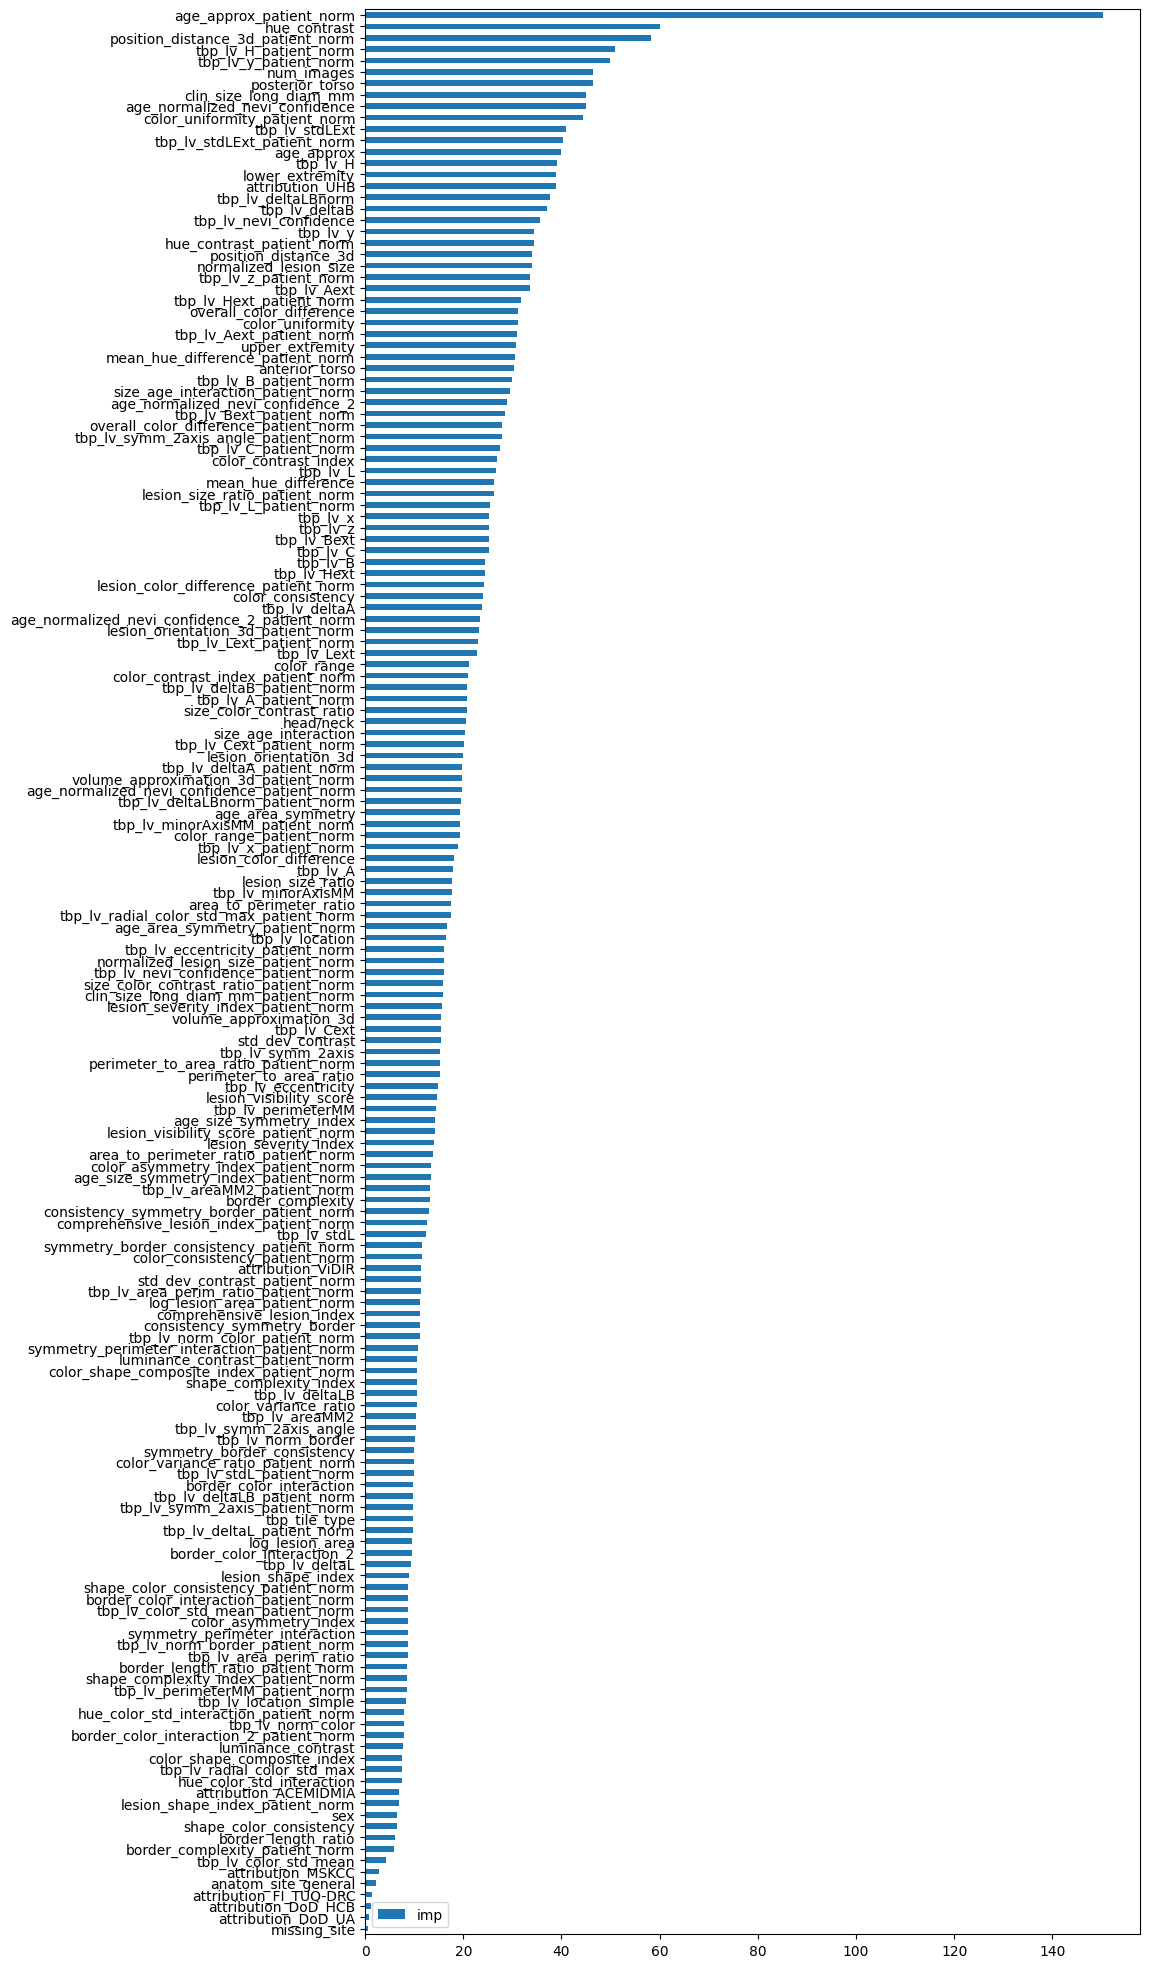

In [11]:
feature_importances = 0
for fold in all_folds:
    if fold < 0:
        continue
    model_filepath = MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt"
    with open(model_filepath, "rb") as f:
        model = joblib.load(f)
    if fold == 1:
        feature_names = model._final_estimator.feature_name_
    feature_importances += model._final_estimator.feature_importances_
feature_importances = feature_importances.astype(np.float32)
feature_importances /= len(all_folds)

imp = pd.DataFrame.from_dict(dict(zip(feature_names, feature_importances)), 
                             orient="index", columns=["imp"]).sort_values("imp", ascending=True)
imp.plot(kind="barh", figsize=(10, 25))

metadata = {
    "params": params,
    "num_rounds": num_rounds,
    "es_rounds": es_rounds,
    "best_num_rounds": best_num_rounds,
    "val_auc_scores": val_auc_scores,
    "val_pauc_scores": val_pauc_scores,
    "cv_auc_oof": cv_auc_oof,
    "cv_pauc_oof": cv_pauc_oof,
    "cv_auc_avg": cv_auc_avg,
    "cv_pauc_avg": cv_pauc_avg,
    "cv_auc_std": cv_auc_std,
    "cv_pauc_std": cv_pauc_std
}

with open(f"{cfg.model_name}_run_metadata.json", "w") as f:
    json.dump(metadata, f)